In [1]:
!pip install scikit-survival
!pip install scikit-learn
!pip install pycox
!pip install captum

You should consider upgrading via the '/home/jskrajny/PycharmProjects/xai_team/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/jskrajny/PycharmProjects/xai_team/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/jskrajny/PycharmProjects/xai_team/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/jskrajny/PycharmProjects/xai_team/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import sklearn.model_selection as model_selection

import torch
import torchtuples

import sksurv.datasets as datasets
import sksurv.linear_model as linear_model
import sksurv.ensemble as ensemble
import sksurv.functions as functions

import pycox
from pycox.datasets import metabric, nwtco
import pycox.evaluation as evaluation

import captum.attr as attr
import survshap

import matplotlib.pyplot as plt

import torchtuples as tt

In [3]:
class DeepHitSingleWrapper:
    def __init__(self, net, optim):
        self.net = net
        self.optim = optim
        
    def fit(self, train_data, train_target, val_data, val_target, callbacks, epochs=10):
        cuts = self.net.net[-1].out_features
        lt = pycox.models.DeepHitSingle.label_transform(cuts)
        
        train_data = train_data.values
        train_target = lt.fit_transform(train_target["duration"], train_target["event"])
        
        val_data = val_data.values
        val_target = lt.transform(val_target["duration"], val_target["event"])
        
        self.model = pycox.models.DeepHitSingle(self.net, self.optim, device='cpu', duration_index=lt.cuts)
        log = self.model.fit(train_data, train_target, 256, epochs=epochs, callbacks=callbacks, val_data=(val_data, val_target))
        
        self.event_times_ = lt.cuts

        return log

    def predict_surv_df(self, data):
        return self.model.predict_surv_df(data.values)
        
    def score(self, data, target):
        surv_df = self.predict_surv_df(data)
        eval_surv = evaluation.EvalSurv(surv_df, target["duration"], target["event"])
        
        return eval_surv.concordance_td()
    
    def predict_survival_function(self, data):
        surv_df = self.predict_surv_df(data)
        ret = [functions.StepFunction(surv_df.index.values, values) for values in surv_df.T.values]
        
        return np.array(ret)

In [4]:
import time


class Wrapper:
    def __init__(self, model, data, explainer):
        self.model = model
        self.baseline = torch.zeros(data.values.shape)
        self.explainer = explainer(self.model.net)
        
    def __call__(self, observation):
        data = torch.tensor(observation.values)

        attributions = []
        st = time.time()
        for i in range(len(self.model.event_times_)):
            attribution = self.explainer.attribute(data, self.baseline, i).detach().numpy()
            attributions.append(attribution)
        attributions = np.stack(attributions, axis=2)

        print(f"Explainer working time in seconds = {time.time() - st}")

        step_functions = {}
        for i, column in enumerate(observation.columns):
            step_functions[column] = [
                functions.StepFunction(self.model.event_times_, np.cumsum(attributions[j, i])) \
                for j in range(len(observation))
            ]

        return pd.DataFrame(step_functions)

In [5]:
class DeepLiftShapWrapper(Wrapper):
    def __init__(self, model, data):
        super(DeepLiftShapWrapper, self).__init__(model, data, attr.DeepLiftShap)
        
        self.model = model
        self.baseline = torch.randn(data.values.shape) * 0.001
        self.explainer = attr.DeepLiftShap(self.model.net)

In [6]:
class DeepLiftWrapper(Wrapper):
    def __init__(self, model, data):
        super(DeepLiftWrapper, self).__init__(model, data, attr.DeepLift)
        
        self.model = model
        self.baseline = torch.zeros((1, data.values.shape[1]))
        self.explainer = attr.DeepLift(self.model.net)

In [7]:
class IntegratedGradientsWrapper(Wrapper):
    def __init__(self, model, data):
        super(IntegratedGradientsWrapper, self).__init__(model, data, attr.DeepLiftShap)
        
        self.model = model
        self.baseline = torch.zeros((1, data.values.shape[1]))
        self.explainer = attr.IntegratedGradients(self.model.net)

In [8]:
class SurvShapWrapper:
    def __init__(self, model, data, target):
        self.model = model
        self.explainer = survshap.SurvivalModelExplainer(self.model, data, target)

    def __call__(self, observation):     
        surv_shap = survshap.PredictSurvSHAP()
        st = time.time()
        surv_shap.fit(self.explainer, observation, self.model.event_times_)
        print(f"Explainer working time in seconds = {time.time() - st}")
        result = surv_shap.result
        
        step_functions = {}
        for name, group in result.groupby(by="variable_name"):            
            step_functions[name] = [
                functions.StepFunction(self.model.event_times_, attributions)
                for attributions in group.iloc[:, 5:].values
            ]
            
        return pd.DataFrame(step_functions)

In [9]:
def plot(results):
    Xs = [result.x for result in results]
    Ys = [result.y for result in results]
    labels = list(results.index)

    plt.plot(np.array(Xs).T, np.array(Ys).T, label=labels)
    plt.legend(bbox_to_anchor=(1, 1))

# METABRIC EXPERIMENT - The Molecular Taxonomy of Breast Cancer International Consortium

x0 - MKI67
x1 - EGFR
x2 - PGR
x3 - ERBB2
x4 - hormone treatment indicator
x5 - radiotherapy indicator
x6 - chemotherapy indicator
x7 - ER-positive indicator
x8 - age at diagnosis

In [24]:
df = metabric.read_df()

data, target = datasets.get_x_y(df, attr_labels=["event", "duration"], pos_label=1)
train_data, test_data, train_target, test_target = model_selection.train_test_split(data, target)

for feature_name in train_data.columns:
    max_value = train_data[feature_name].max()
    min_value = train_data[feature_name].min()
    train_data[feature_name] = (train_data[feature_name] - min_value) / (max_value - min_value)
    test_data[feature_name] = (test_data[feature_name] - min_value) / (max_value - min_value)
train_data, train_target

(            x0        x1        x2        x3   x4   x5   x6   x7        x8
 493   0.024114  0.094836  0.668063  0.499578  1.0  0.0  0.0  1.0  0.571140
 507   0.063961  0.802279  0.503265  0.203685  1.0  1.0  0.0  1.0  0.567375
 405   0.211244  0.365733  0.555867  0.240377  0.0  0.0  0.0  1.0  0.243545
 67    0.226682  0.117200  0.416762  0.232201  1.0  0.0  0.0  1.0  0.399274
 1112  0.091678  0.414578  0.517204  0.225913  0.0  1.0  0.0  1.0  0.550968
 ...        ...       ...       ...       ...  ...  ...  ...  ...       ...
 525   0.239324  0.218224  0.487622  0.127104  1.0  0.0  0.0  1.0  0.651156
 354   0.348225  0.127246  0.498213  0.751849  1.0  0.0  1.0  0.0  0.422539
 1680  0.073574  0.390495  0.634369  0.523202  1.0  1.0  0.0  1.0  0.528376
 1155  0.069091  0.313804  0.643573  0.655238  1.0  1.0  0.0  1.0  0.675632
 996   0.086551  0.132912  0.485925  0.384221  1.0  1.0  1.0  1.0  0.410167
 
 [1428 rows x 9 columns],
 array([(False, 111.6333313 ), ( True, 199.2666626 ),
      

## TRAINING

#### METABRIC - RANDOM FOREST

In [11]:
random_survival_forest = ensemble.RandomSurvivalForest()
random_survival_forest.fit(train_data, train_target)

print(f"Train score = {random_survival_forest.score(train_data, train_target)}")
print(f"Test score = {random_survival_forest.score(test_data, test_target)}")

Train score = 0.8902796057049234
Test score = 0.6239168334732356


#### METABRIC - COXPH

In [12]:
CoxPH_survival_analysis = linear_model.CoxPHSurvivalAnalysis()
CoxPH_survival_analysis.fit(train_data, train_target)

print(f"Train score = {CoxPH_survival_analysis.score(train_data, train_target)}")
print(f"Test score = {CoxPH_survival_analysis.score(test_data, test_target)}")

Train score = 0.650540226099077
Test score = 0.6033318266933557


#### METABRIC - DEEPHIT

0:	[0s / 0s],		train_loss: 0.9026,	val_loss: 0.8681
1:	[0s / 0s],		train_loss: 0.8949,	val_loss: 0.8669
2:	[0s / 0s],		train_loss: 0.8853,	val_loss: 0.8666
3:	[0s / 0s],		train_loss: 0.8848,	val_loss: 0.8664
4:	[0s / 0s],		train_loss: 0.8806,	val_loss: 0.8659
5:	[0s / 0s],		train_loss: 0.8821,	val_loss: 0.8648
6:	[0s / 0s],		train_loss: 0.8734,	val_loss: 0.8633
7:	[0s / 0s],		train_loss: 0.8703,	val_loss: 0.8617
8:	[0s / 0s],		train_loss: 0.8591,	val_loss: 0.8603
9:	[0s / 0s],		train_loss: 0.8624,	val_loss: 0.8593
10:	[0s / 1s],		train_loss: 0.8622,	val_loss: 0.8583
11:	[0s / 1s],		train_loss: 0.8618,	val_loss: 0.8572
12:	[0s / 1s],		train_loss: 0.8616,	val_loss: 0.8561
13:	[0s / 1s],		train_loss: 0.8526,	val_loss: 0.8551
14:	[0s / 1s],		train_loss: 0.8557,	val_loss: 0.8538
15:	[0s / 1s],		train_loss: 0.8523,	val_loss: 0.8527
16:	[0s / 1s],		train_loss: 0.8458,	val_loss: 0.8516
17:	[0s / 1s],		train_loss: 0.8455,	val_loss: 0.8507
18:	[0s / 1s],		train_loss: 0.8516,	val_loss: 0.8498
19:

/home/jskrajny/PycharmProjects/xai_team/venv/lib/python3.8/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/home/jskrajny/PycharmProjects/xai_team/venv/lib/python3.8/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


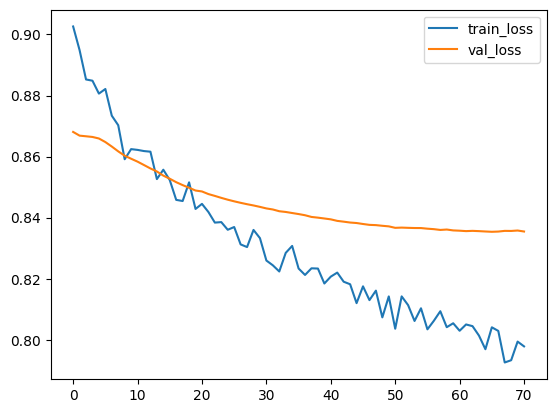

In [26]:
net = torchtuples.practical.MLPVanilla(train_data.shape[1], [16, 16], 100)
optim = torch.optim.Adam(net.parameters(), lr=5e-4)

deep_hit_single = DeepHitSingleWrapper(net, optim)
log = deep_hit_single.fit(train_data, train_target, test_data, test_target, [tt.callbacks.EarlyStopping(patience=5)], epochs=100)

print(f"Train score = {deep_hit_single.score(train_data, train_target)}")
print(f"Test score = {deep_hit_single.score(test_data, test_target)}")

_ = log.plot()

## EXPLAINING

#### METABRIC - SURVSHAP - COXPH

Explainer working time in seconds = 24.846624612808228


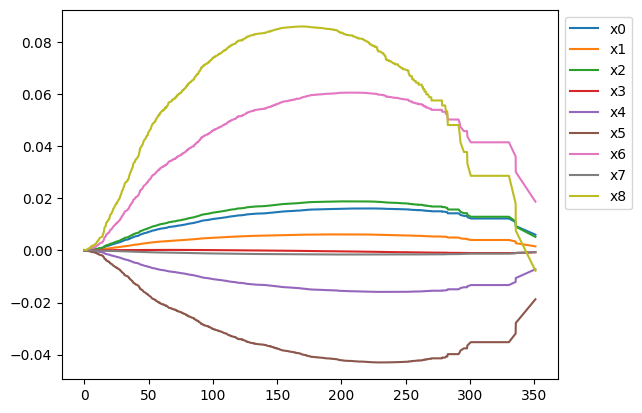

In [14]:
surv_shap_wrapper = SurvShapWrapper(CoxPH_survival_analysis, test_data, test_target)
surv_shap_results = surv_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(surv_shap_results)

#### METABRIC - SURVSHAP - RANDOM FOREST

Explainer working time in seconds = 67.68577146530151


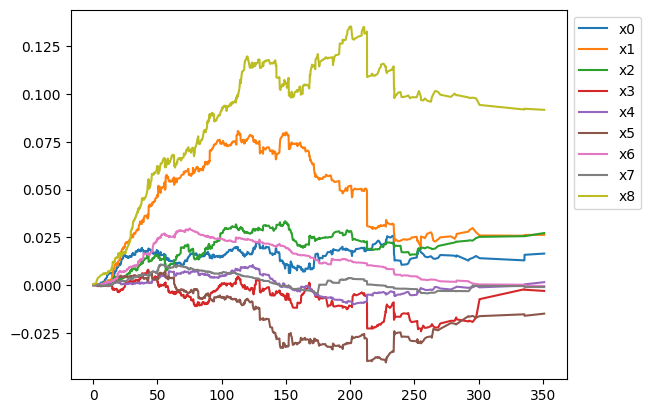

In [15]:
surv_shap_wrapper = SurvShapWrapper(random_survival_forest, test_data, test_target)
surv_shap_results = surv_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(surv_shap_results)

#### METABRIC - SURVSHAP - DEEPHIT

Explainer working time in seconds = 11.042371273040771


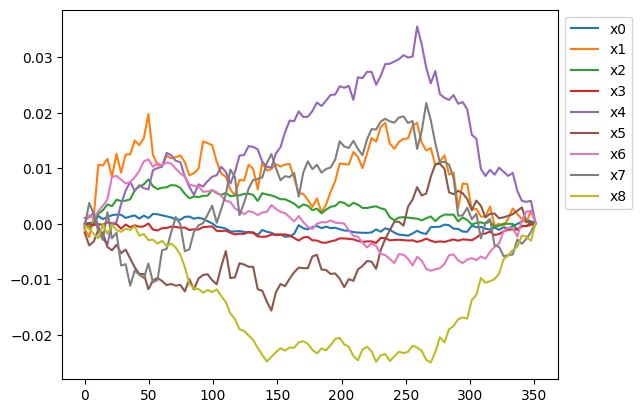

In [27]:
surv_shap_wrapper = SurvShapWrapper(deep_hit_single, test_data, test_target)
surv_shap_results = surv_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(surv_shap_results)

#### METABRIC - DEEPLIFT - DEEPHIT

/home/jskrajny/PycharmProjects/xai_team/venv/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Explainer working time in seconds = 0.8885498046875


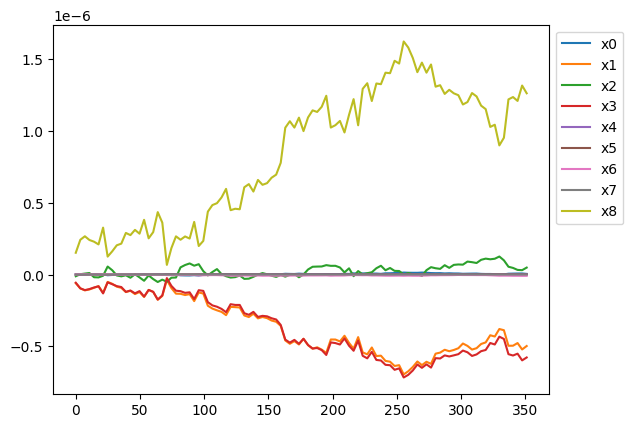

In [28]:
deep_lift_shap_wrapper = DeepLiftShapWrapper(deep_hit_single, test_data)
deep_lift_shap_results = deep_lift_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(deep_lift_shap_results)

#### METABRIC - INTEGRATED GRADIENT - DEEPHIT

Explainer working time in seconds = 1.3948235511779785


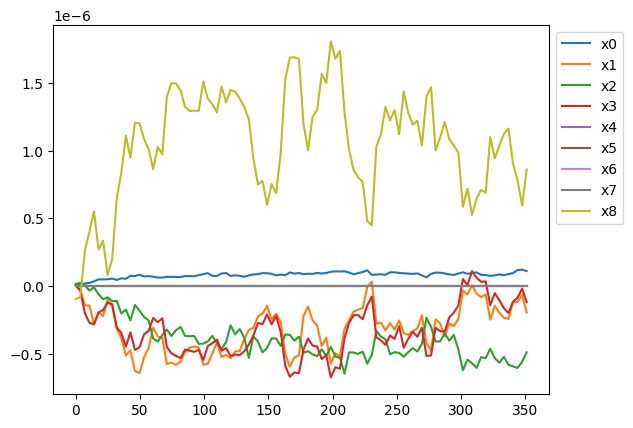

In [29]:
integrated_gradient_wrapper = IntegratedGradientsWrapper(deep_hit_single, test_data)
integrated_gradient_results = integrated_gradient_wrapper(test_data.iloc[[0]]).iloc[0]

plot(integrated_gradient_results)

# SUPPORT EXPERIMENT - Study to Understand Prognoses Preferences Outcomes and Risks of Treatment

x0 - age
x1 - sex
x2 - race
x3 - number of comorbidities
x4 - presence of diabetes
x5 - presence of dementia
x6 - presence of cancer
x7 - mean arterial blood pressure
x8 - heart rate
x9 - respiration rate
x10 - temperature
x11 - white blood cell count
x12 - serum’s sodium
x13 - and serum’s creatinine

In [30]:
from pycox.datasets import support

df = support.read_df()
data, target = datasets.get_x_y(df, attr_labels=["event", "duration"], pos_label=1)
train_data, test_data, train_target, test_target = model_selection.train_test_split(data, target)

for feature_name in train_data.columns:
    max_value = train_data[feature_name].max()
    min_value = train_data[feature_name].min()
    train_data[feature_name] = (train_data[feature_name] - min_value) / (max_value - min_value)
    test_data[feature_name] = (test_data[feature_name] - min_value) / (max_value - min_value)
train_data, train_target

(            x0   x1        x2   x3   x4   x5   x6        x7     x8        x9  \
 3438  0.155251  1.0  0.222222  0.2  0.0  0.0  1.0  0.261538  0.536  0.133333   
 3219  0.529306  0.0  0.222222  0.2  0.0  0.0  0.0  0.369231  0.300  0.100000   
 7268  0.620719  0.0  0.444444  0.6  1.0  0.0  0.5  0.569231  0.320  0.177778   
 141   0.722872  1.0  0.555556  0.2  0.0  0.0  0.5  0.333333  0.400  0.311111   
 4305  0.550999  1.0  0.222222  0.2  0.0  0.0  0.0  0.312821  0.404  0.244444   
 ...        ...  ...       ...  ...  ...  ...  ...       ...    ...       ...   
 3269  0.475169  0.0  0.111111  0.2  0.0  0.0  0.5  0.384615  0.248  0.466667   
 4067  0.644297  1.0  0.333333  0.2  0.0  0.0  0.5  0.466667  0.384  0.244444   
 2458  0.155025  1.0  0.111111  0.2  0.0  0.0  1.0  0.564103  0.496  0.355556   
 4351  0.442964  0.0  0.222222  0.2  0.0  0.0  0.5  0.271795  0.468  0.322222   
 5779  0.553027  1.0  0.000000  0.2  0.0  0.0  0.5  0.512821  0.520  0.266667   
 
            x10       x11 

## TRAINING

#### SUPPORT - RANDOM FOREST

In [31]:
random_survival_forest = ensemble.RandomSurvivalForest()
random_survival_forest.fit(train_data, train_target)

print(f"Train score = {random_survival_forest.score(train_data, train_target)}")
print(f"Test score = {random_survival_forest.score(test_data, test_target)}")

Train score = 0.8389961262109014
Test score = 0.6139028974092138


#### SUPPORT - COXPH

In [39]:
CoxPH_survival_analysis = linear_model.CoxPHSurvivalAnalysis()
CoxPH_survival_analysis.fit(train_data, train_target)

print(f"Train score = {CoxPH_survival_analysis.score(train_data, train_target)}")
print(f"Test score = {CoxPH_survival_analysis.score(test_data, test_target)}")

Train score = 0.5733937411854154
Test score = 0.5654284451862205


#### SUPPORT - DEEPHIT

0:	[0s / 0s],		train_loss: 1.2725,	val_loss: 1.2605
1:	[0s / 0s],		train_loss: 1.2604,	val_loss: 1.2601
2:	[0s / 0s],		train_loss: 1.2517,	val_loss: 1.2572
3:	[0s / 1s],		train_loss: 1.2425,	val_loss: 1.2535
4:	[0s / 1s],		train_loss: 1.2346,	val_loss: 1.2466
5:	[0s / 2s],		train_loss: 1.2266,	val_loss: 1.2411
6:	[0s / 2s],		train_loss: 1.2185,	val_loss: 1.2346
7:	[0s / 2s],		train_loss: 1.2112,	val_loss: 1.2289
8:	[0s / 3s],		train_loss: 1.2025,	val_loss: 1.2216
9:	[0s / 3s],		train_loss: 1.1940,	val_loss: 1.2157
10:	[0s / 3s],		train_loss: 1.1860,	val_loss: 1.2087
11:	[0s / 4s],		train_loss: 1.1772,	val_loss: 1.2027
12:	[0s / 4s],		train_loss: 1.1685,	val_loss: 1.1956
13:	[0s / 4s],		train_loss: 1.1600,	val_loss: 1.1891
14:	[0s / 4s],		train_loss: 1.1506,	val_loss: 1.1829
15:	[0s / 5s],		train_loss: 1.1424,	val_loss: 1.1753
16:	[0s / 5s],		train_loss: 1.1329,	val_loss: 1.1697
17:	[0s / 5s],		train_loss: 1.1237,	val_loss: 1.1637
18:	[0s / 5s],		train_loss: 1.1152,	val_loss: 1.1569
19:

/home/jskrajny/PycharmProjects/xai_team/venv/lib/python3.8/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Train score = 0.6316960621973184
Test score = 0.6061618142280903


/home/jskrajny/PycharmProjects/xai_team/venv/lib/python3.8/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


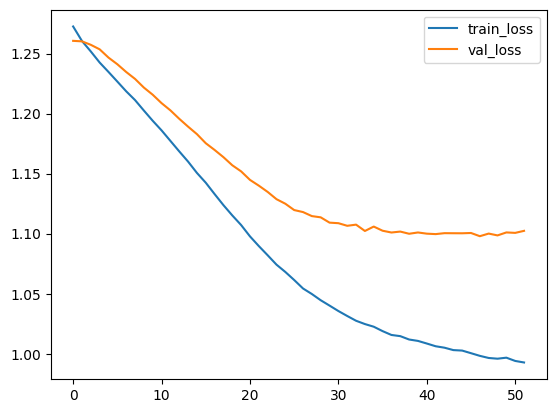

In [33]:
net = torchtuples.practical.MLPVanilla(train_data.shape[1], [32, 32], 500)
optim = torch.optim.Adam(net.parameters(), lr=5e-4)

deep_hit_single = DeepHitSingleWrapper(net, optim)
log = deep_hit_single.fit(train_data, train_target, test_data, test_target, [tt.callbacks.EarlyStopping(patience=5)], epochs=100)

print(f"Train score = {deep_hit_single.score(train_data, train_target)}")
print(f"Test score = {deep_hit_single.score(test_data, test_target)}")

_ = log.plot()

## EXPLAINING

#### SUPPORT - SURVSHAP - COXPH

Explainer working time in seconds = 1387.2153100967407


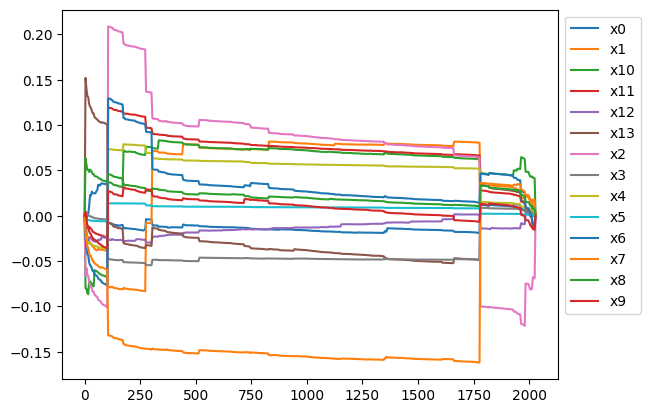

In [40]:
urv_shap_wrapper = SurvShapWrapper(CoxPH_survival_analysis, test_data, test_target)
surv_shap_results = surv_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(surv_shap_results)

#### SUPPORT - SURVSHAP - RANDOM FOREST

Explainer working time in seconds = 8662.64719581604


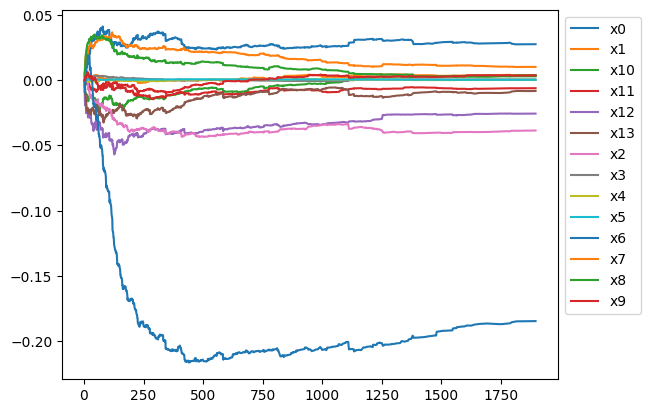

In [41]:
surv_shap_wrapper = SurvShapWrapper(random_survival_forest, test_data, test_target)
surv_shap_results = surv_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(surv_shap_results)

#### SUPPORT - SURVSHAP - DEEPHIT

Explainer working time in seconds = 1276.2100977897644


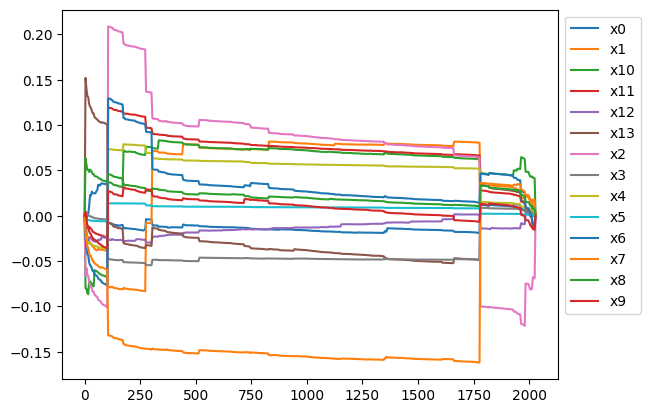

In [42]:
surv_shap_wrapper = SurvShapWrapper(deep_hit_single, test_data, test_target)
surv_shap_results = surv_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(surv_shap_results)

#### SUPPORT - DEEPLIFT - DEEPHIT

/home/jskrajny/PycharmProjects/xai_team/venv/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Explainer working time in seconds = 37.401450872421265


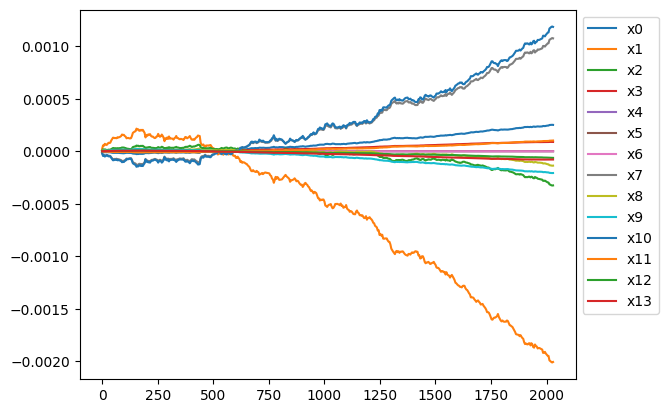

In [36]:
deep_lift_shap_wrapper = DeepLiftShapWrapper(deep_hit_single, test_data)
deep_lift_shap_results = deep_lift_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(deep_lift_shap_results)

#### SUPPORT - INTEGRATED GRADIENTS - DEEPHIT

Explainer working time in seconds = 4.688051462173462


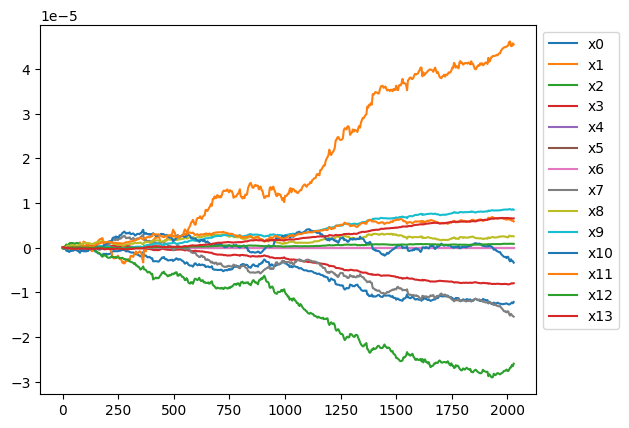

In [37]:
integrated_gradient_wrapper = IntegratedGradientsWrapper(deep_hit_single, test_data)
integrated_gradient_results = integrated_gradient_wrapper(test_data.iloc[[0]]).iloc[0]

plot(integrated_gradient_results)